<a href="https://colab.research.google.com/github/ARU-Bioinformatics/advanced-programming-SBV/blob/main/seeing_the_light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Systems Biology: circadian rhythms from genes to cells

In this notebook we will explore computationally how biological systems integrate cellulat signals between tissues in the same organ. The data on the course page is required to be placed in a directory called ```/input ``` to make the script work out of the box. Typically in physiology we work with large amounts of image data. In the past twenty years the scope of bioinformaticians to work with imaging data has massively increased, as increasing complexity can be measured from imaging experiments. This dataset, taken from the brain of a mouse expressing the reporter gene PER1:GFP is a nice example of how we can exploit simple data science principles, such as k-means clustering, to increase our understanding of biological systems.


Based on the works of Kevin Mader and Peter Grenholm

### Introduction
We use a fluorescent protein as a reporter for the circadian clock gene Period1. We are able to follow the expression of this gene in many neurons for several days to understand how the neural network in the suprachiasmatic nucleus synchronizes the circadian clock of individual neurons to produce a precise circadian rhythm. We analyze each image to determine the fluorescence intensity of each neuron over multiple
circadian cycles.

*   How where the images obtained: which animal and what staining?
The images were taken from a transgenic mouse in which expression of the fluorescent protein Venus is driven by the promoter for the circadian clock gene Period 1.

*    What is the anatomy of the images, and how are they oriented?
The bright line is the third ventricle, which resides on the midline of the brain. The two bright regions on either side of the ventricle are the two portions of the Suprachiasmatic nucleus (SCN). Below the ventricle and the SCN is a dark horizontal band that represents the optic chasm.

*    What is the bright vertical line in the top middle?
The bright line is the third ventricle. Pericytes that line the ventricle express the Venus at very high levels. We don't know the function of the circadian clock in these cells.

### Challenge
Currently the researchers analyse each experiment by hand to follow an individual through a couple hundred images. This takes several days. This problem is going to get worse because with advancements in automated microscopy to simultaneously image from multiple animals. Can we utilsie data science skills to make life bearable? Unsurprisingly, the answer is yes!!

## Set-up the environment

In [ ]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # graphs
%matplotlib inline
from scipy.ndimage.filters import uniform_filter # to smooth images
import os
import copy
import skimage.feature
from sklearn.linear_model import LinearRegression
import astropy.stats as ap
from sklearn.cluster import KMeans
#import photutils as pu

## Bring in the data

In [ ]:
wd = "../input"
print(os.listdir(wd))
datafile = os.path.join(wd, "data141110.csv")
data = np.loadtxt(datafile, delimiter=',', skiprows=1)
image_no=data[:,0].reshape(-1,1)
frame_no=data[:,1].reshape(-1,1)
time_hrs=data[:,2].reshape(-1,1)
nb_images = data.shape[0]

['data141110.csv', 'flo_images', 'flo_image_1.npz', 'flo_image_2.npz']


In [ ]:
flo1file = os.path.join(wd, "flo_image_1.npz")
flo2file = os.path.join(wd, "flo_image_2.npz")
flo_image_1 = np.load(flo1file)
flo_image_2 = np.load(flo2file)
# group the data from the 2 files
image_ids = np.concatenate([flo_image_1['image_ids'], flo_image_2['image_ids']])
images = np.concatenate([flo_image_1['image_stack'], flo_image_2['image_stack']])
# these object are no more useful, free memory
del flo_image_1, flo_image_2

After removing the trend, we do a spectral analysis of the data.

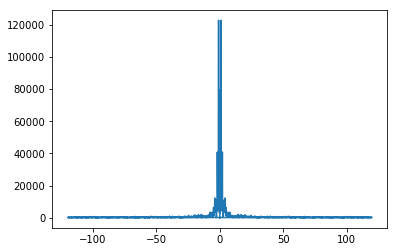

In [ ]:
mean_values = np.mean(images, axis=(1,2))
model = LinearRegression()
model.fit(time_hrs, mean_values)
mean_linear = model.predict(time_hrs)
norm_values = mean_values - mean_linear
ffit = np.fft.fft(norm_values)
freqs = np.fft.fftfreq(ffit.shape[-1])
dfreqs = freqs*240
rffit = np.real(ffit)
cffit = np.imag(ffit)
power = np.sqrt(rffit*rffit+cffit*cffit)
plt.plot(dfreqs, power)

Units of the horizontal axis are "per day". 2, for example, is "twice a day". It seems that most of the signal is concentrated around the center, in the lowest frequencies. Let's zoom on this zone

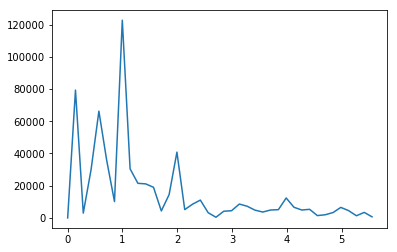

In [ ]:
plt.plot(dfreqs[0:40], power[0:40])

The biggest peak is near 1: once a day - 24 hrs period. The 2 peaks just before are artefacts, linked to the number of measurements and its third harmonic. Let's have a look at the values of the highest peaks:

In [ ]:
indices = power>40000
pics = dfreqs[indices]
print(pics)
periodes = 1/pics
print(periodes)
print (power[indices])

[ 0.14243323  0.56973294  0.99703264  1.99406528 -1.99406528 -0.99703264
 -0.56973294 -0.14243323]
[ 7.02083333  1.75520833  1.00297619  0.5014881  -0.5014881  -1.00297619
 -1.75520833 -7.02083333]
[  79293.68525309   66238.62894969  122645.52222355   40817.05239702
   40817.05239702  122645.52222355   66238.62894969   79293.68525309]


The first 2 peaks are the artifacts mentioned above (7.02 days is the duration of the measurements). The third and highest peak has a frequency of 1/day (or a period of one day), and the next one is its second harmonic (2/day).

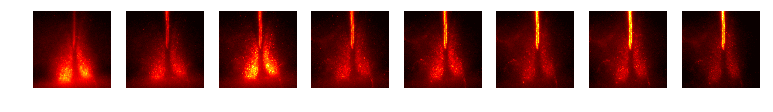

In [ ]:
fix, ax = plt.subplots(1,8, figsize=(13,8))
idx = [80, 200, 320, 440, 560, 740, 860, 980]
for j in range(8):
    ax[j].set_axis_off()
    ax[j].imshow(images[idx[j],:,:] - mean_linear[idx[j]], cmap='hot', vmin=-800, vmax=6400)
        

This shows at least 2 different behaviours: the 2 lobes below, and the vertical segment above. Let's check with K-Means

In [ ]:
# reshape the data to be compatible with K-Means
imagesshape = images.shape
images = np.transpose(images.reshape(imagesshape[0], -1))
sets = 10 #number of regions we want to see
nimages=1685
sampling=3 #sampling factor: 3 is sample every third image. Needed to stay within the memory bounds
model = KMeans(n_clusters = sets, n_jobs=1)
clusters = model.fit(images[:, 0:nimages:sampling])
centroids = clusters.cluster_centers_

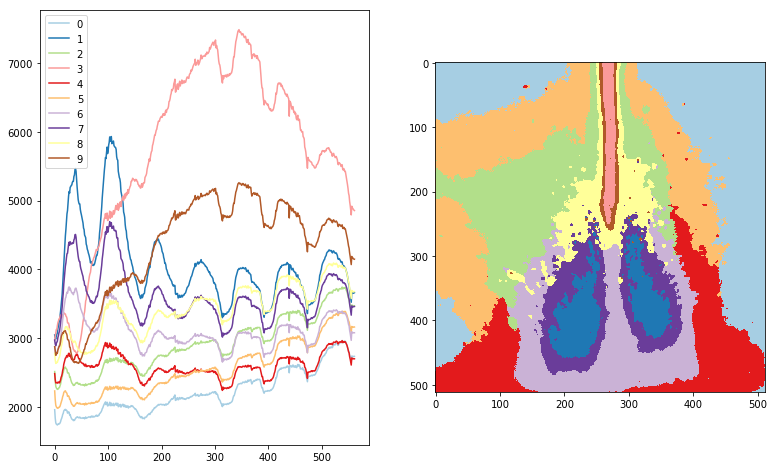

In [ ]:
cmap = plt.get_cmap('Paired')
fig3, ax3 = plt.subplots(1,2, figsize=(13,8))
colors = [cmap(i) for i in np.linspace(0, 1, sets)]
for i in range(0, sets):
    ax3[0].plot(centroids[i], color=colors[i], label=i)
ax3[0].legend(loc=0)
zones = clusters.predict(images[:,0:nimages:sampling])
image = copy.deepcopy(zones)
image = image.reshape(512, 512)
ax3[1].imshow(image, cmap='Paired')

The same colors are used in both visualisations.

We can see 2 substantially different behaviours:

*    the 2 lobes show a distinct daily variation, and a lightly increasing or decreasing trend
*   the vertical segment, where the daily variation is less clear, and which shows a growing trend.



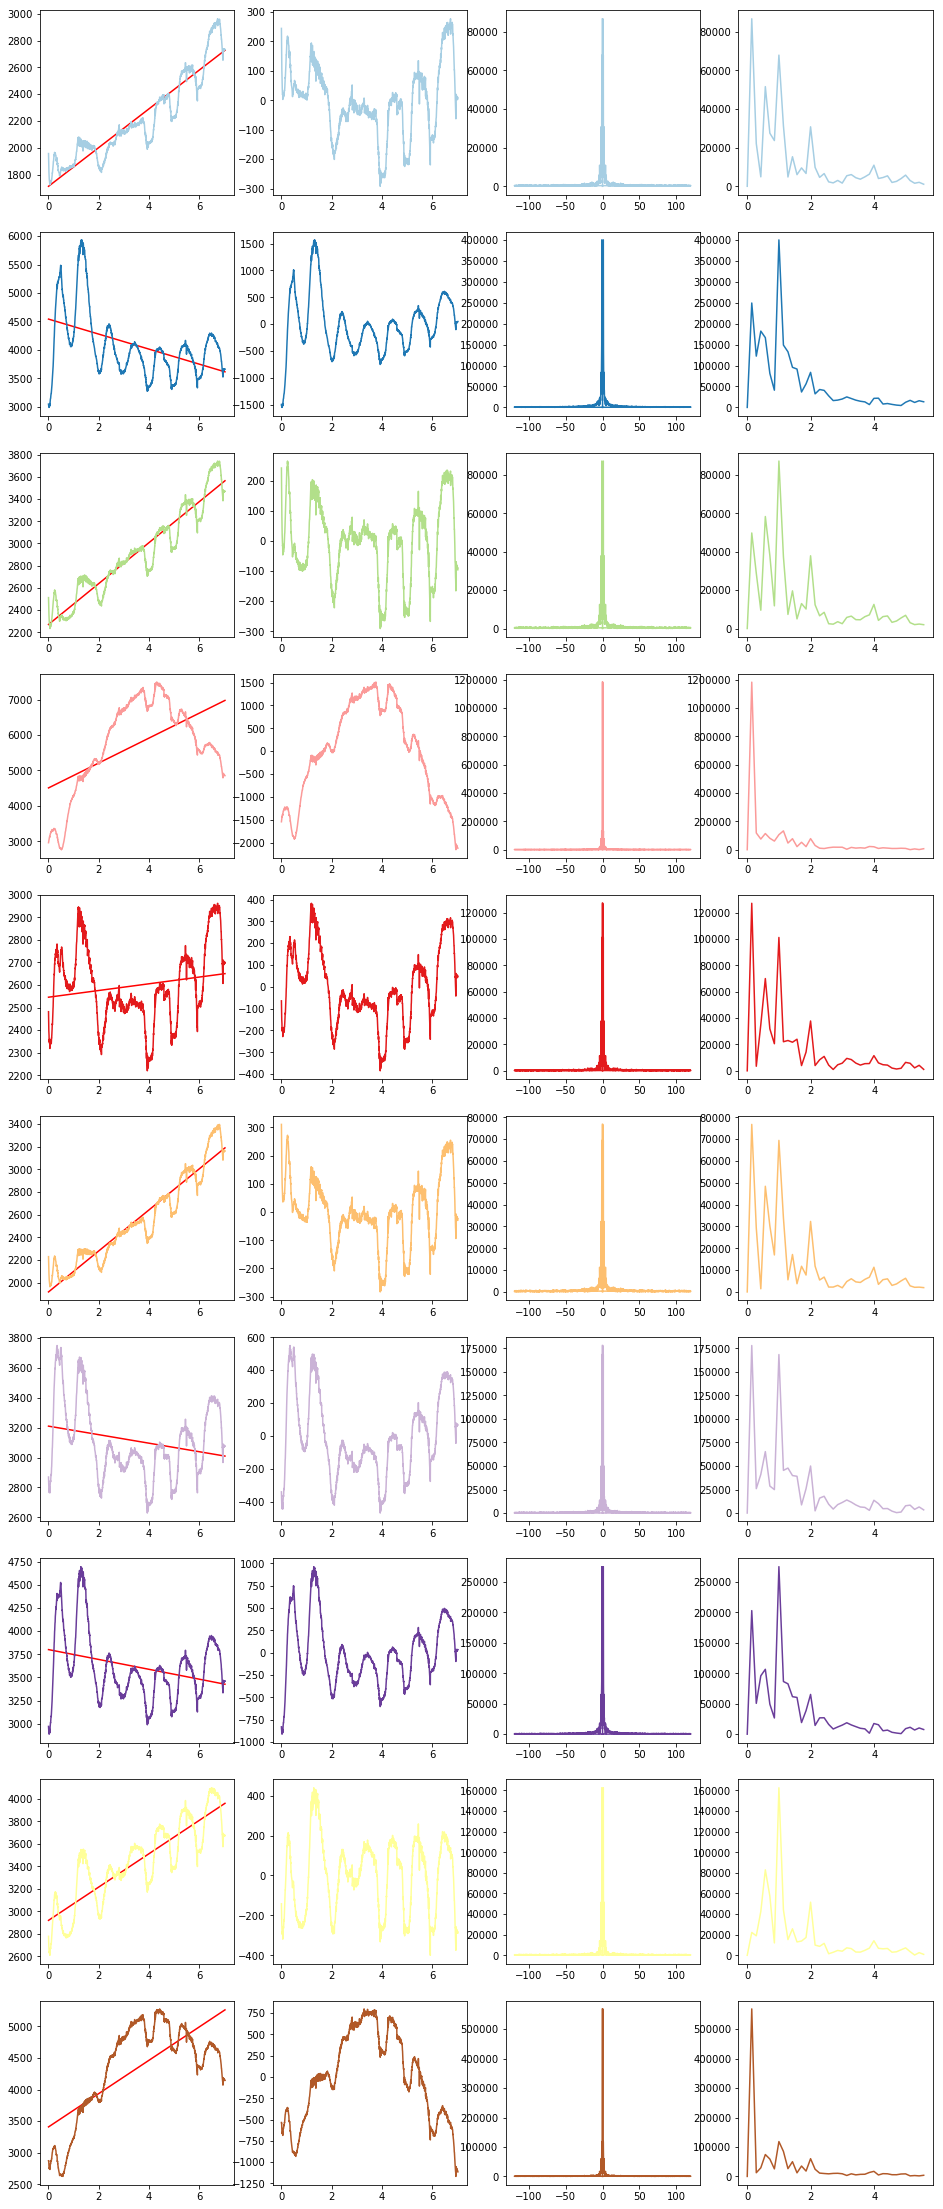

In [ ]:
fig4, ax4 = plt.subplots(sets,4, figsize=(16, 4*sets))
for seq in range(0, sets):
    category = images[zones==seq,:]
    serie = np.mean(category, axis = 0)
    days = data[:,1].reshape(-1,1)/240
    model = LinearRegression()
    model.fit(days, serie)
    ax4[seq, 0].plot(days, model.predict(days), 'r')
    ax4[seq, 0].plot(days, serie, color = colors[seq])
    model_value = model.predict(days)
    detrended = serie - model_value
    ax4[seq, 1].plot(days, detrended, color = colors[seq])
    ffit = np.fft.fft(detrended)
    freqs = np.fft.fftfreq(ffit.shape[-1])*240
    rffit = np.real(ffit)
    cffit = np.imag(ffit)
    power = np.sqrt(rffit*rffit+cffit*cffit)
    ax4[seq, 2].plot(freqs, power, color = colors[seq])
    ax4[seq, 3].plot(freqs[0:40], power[0:40], color = colors[seq])

For each "zone" of the image, as computed by K-Means, we show:

* The average light curve over time, with a trend line calculated by linear regression
* The detrended signal
* The Fourier transform
* a zoom over the lowest frequencies of the Fourier transform

The colors are the same as in the previous graph, so that one can identify the regions of the image by color.

We see that:

* There is a strong daily variation in the central zone of the lobes, which is decreasing in the peripheral zones
* There is no daily signal in the upper segment and its periphery

The K-Means algorithm has detected zones with different behaviours, and the individual zones are better characterised than the global average.

To go further, I probably need some domain expertise in the brain anatomy and physiology.